<a href="https://colab.research.google.com/github/springboardmentor458/OBJECT_RECOGNITION_SYSTEM_Infosys_Internship_Oct2024/blob/Sakthivel/Faster_r_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q pycocotools

In [21]:
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 3.4 MB/s eta 0:00:00


In [22]:
# !kaggle datasets download -d awsaf49/coco-2017-dataset/val2017

import patoolib
patoolib.extract_archive('/content/val2017-20241107T140810Z-001.zip')
# ! unzip "" -d 'dataset'

INFO patool: Extracting /content/val2017-20241107T140810Z-001.zip ...
INFO:patool:Extracting /content/val2017-20241107T140810Z-001.zip ...
INFO patool: running /usr/bin/7z x -aou -o./Unpack_b3vejng8 -- /content/val2017-20241107T140810Z-001.zip
INFO:patool:running /usr/bin/7z x -aou -o./Unpack_b3vejng8 -- /content/val2017-20241107T140810Z-001.zip
ERROR patool: extraction error, could not remove temporary extraction directory ./Unpack_b3vejng8: [Errno 39] Directory not empty: './Unpack_b3vejng8'
ERROR:patool:extraction error, could not remove temporary extraction directory ./Unpack_b3vejng8: [Errno 39] Directory not empty: './Unpack_b3vejng8'


PatoolError: Command `['/usr/bin/7z', 'x', '-aou', '-o./Unpack_b3vejng8', '--', '/content/val2017-20241107T140810Z-001.zip']' returned non-zero exit status 2

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
import requests
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import random,os
from skimage import io
from pycocotools.coco import COCO
import matplotlib.patches as patches
import time
from tqdm import tqdm
import matplotlib.patches as mpatches
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import cv2
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import average_precision_score

# def calculate_iou(boxA, boxB):
#     xA = max(boxA[0], boxB[0])
#     yA = max(boxA[1], boxB[1])
#     xB = min(boxA[2], boxB[2])
#     yB = min(boxA[3], boxB[3])
#     interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
#     boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
#     boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
#     iou = interArea / float(boxAArea + boxBArea - interArea)
#     return iou

def calculate_iou(boxA, boxB):
    x1A, y1A, x2A, y2A = boxA  # Coordinates of boxA (x1, y1, x2, y2)
    # Convert boxB from (x1, y1, width, height) to (x1, y1, x2, y2)
    x1B, y1B = boxB[0], boxB[1]
    x2B, y2B = boxB[0] + boxB[2], boxB[1] + boxB[3]
    # Calculate intersection coordinates
    xA = max(x1A, x1B)
    yA = max(y1A, y1B)
    xB = min(x2A, x2B)
    yB = min(y2A, y2B)
    # Calculate intersection area
    intersection_area = max(0, xB - xA) * max(0, yB - yA)
    # Calculate areas of both boxes
    boxAArea = (x2A - x1A) * (y2A - y1A)
    boxBArea = (x2B - x1B) * (y2B - y1B)
    # Calculate union area
    union_area = boxAArea + boxBArea - intersection_area
    # Calculate IoU
    iou = intersection_area / float(union_area + 1e-6)  # Adding epsilon to avoid division by zero
    return iou

In [18]:
DATA_PATH = "/content/drive/MyDrive/dataset/val2017"
annFile = Path('/content/instances_val2017.json')
coco = COCO(annFile)
imgIds = coco.getImgIds() # load all validation set ids
annIds = coco.getAnnIds()
anns = coco.loadAnns(annIds)
# print(img[0])
# print(anns[10])
coco_names = ["person" , "bicycle" , "car" , "motorcycle" , "airplane" , "bus" , "train" , "truck" , "boat" , "traffic light" , "fire hydrant" , "street sign" , "stop sign" , "parking meter" , "bench" , "bird" , "cat" , "dog" , "horse" , "sheep" , "cow" , "elephant" , "bear" , "zebra" , "giraffe" , "hat" , "backpack" , "umbrella" , "shoe" , "eye glasses" , "handbag" , "tie" , "suitcase" ,
"frisbee" , "skis" , "snowboard" , "sports ball" , "kite" , "baseball bat" ,
"baseball glove" , "skateboard" , "surfboard" , "tennis racket" , "bottle" ,
"plate" , "wine glass" , "cup" , "fork" , "knife" , "spoon" , "bowl" ,
"banana" , "apple" , "sandwich" , "orange" , "broccoli" , "carrot" , "hot dog" ,
"pizza" , "donut" , "cake" , "chair" , "couch" , "potted plant" , "bed" ,
"mirror" , "dining table" , "window" , "desk" , "toilet" , "door" , "tv" ,
"laptop" , "mouse" , "remote" , "keyboard" , "cell phone" , "microwave" ,
"oven" , "toaster" , "sink" , "refrigerator" , "blender" , "book" ,
"clock" , "vase" , "scissors" , "teddy bear" , "hair drier" , "toothbrush" , "hair brush"]

loading annotations into memory...
Done (t=0.72s)
creating index...
index created!


In [19]:
from torchvision import transforms
transform = transforms.ToTensor()
coco_dataset = CocoDetection(root=DATA_PATH, annFile=annFile, transform=transform)
data_loader = DataLoader(coco_dataset, batch_size=1, shuffle=False)
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

loading annotations into memory...
Done (t=1.12s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

  0%|          | 0/5000 [00:00<?, ?it/s]

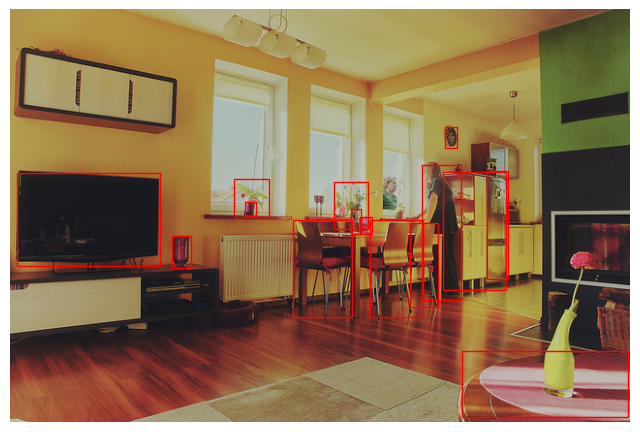

  0%|          | 1/5000 [00:06<8:45:57,  6.31s/it]

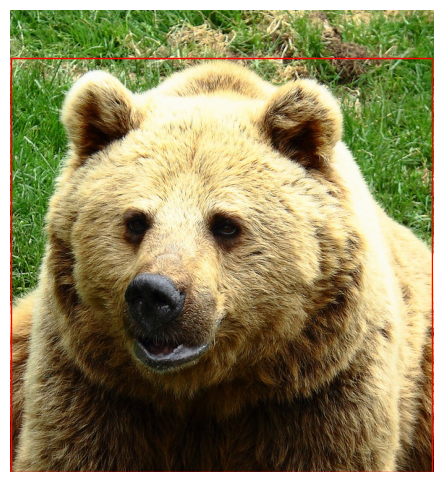

  0%|          | 2/5000 [00:10<6:49:28,  4.92s/it]

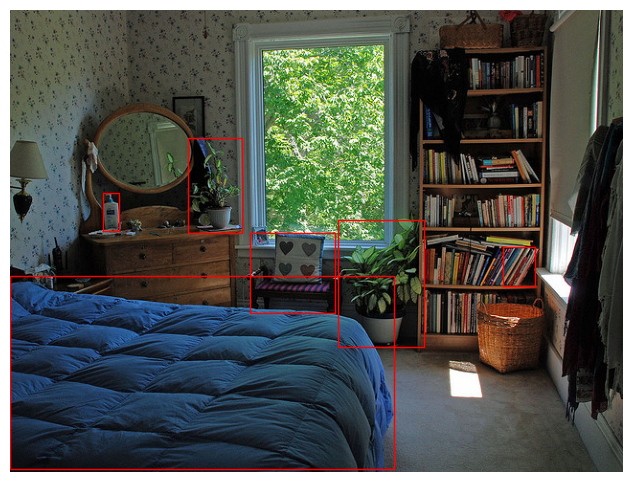

  0%|          | 6/5000 [00:34<8:01:48,  5.79s/it]


In [26]:
score_threshold = 0.85
all_pred_boxes = []
counter = 0
for images, targets in tqdm(data_loader):
    if counter >= 6:
        break
    with torch.no_grad():
        images = list(image for image in images)
        # Forward pass
        predictions = model(images)
        for img, pred in zip(images, predictions):
            counter += 1
            if counter > 3:
                break
            # Convert tensor image to PIL for visualization
            img_pil = to_pil_image(img)
            # Extract predicted boxes and scores above threshold
            pred_boxes = pred['boxes'].detach().numpy()
            scores = pred['scores'].detach().numpy()
            # Filter boxes based on score threshold
            high_score_mask = scores > score_threshold
            pred_boxes = pred_boxes[high_score_mask]
            # Display image with predicted boxes
            plt.figure(figsize=(8, 6))
            plt.imshow(img_pil)
            ax = plt.gca()
            for box in pred_boxes:
                box = list(box)
                rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
            plt.axis('off')
            plt.show()

In [ ]:
# ig=Image.open("/kaggle/input/coco-2017-dataset/coco2017/val2017/000000001296.jpg")
# img=transform(ig)
# with torch.no_grad():
#     predict=model([img])

In [ ]:
# boxes,labels,scores=predict[0]["boxes"],predict[0]["labels"],predict[0]["scores"]
# scores

In [ ]:
# num=torch.argwhere(scores>0.85).shape[0]
# num
# font=cv2.FONT_HERSHEY_COMPLEX
# ig=cv2.imread("/kaggle/input/coco-2017-dataset/coco2017/val2017/000000001296.jpg")

In [ ]:
# for i in range(num):
#     x1,y1,x2,y2=boxes[i].numpy().astype("int")
#     class_label=coco_names[labels.numpy()[i]-1]
#     ig=cv2.rectangle(ig,(x1,y1),(x2,y2),(0,255,0),1)
#     ig=cv2.putText(ig,class_label,(x1,y1-5),font,0.5,(255,0,0),1,cv2.LINE_AA)
# plt.imshow(cv2.cvtColor(ig, cv2.COLOR_BGR2RGB))
# plt.axis('off')  # Hide the axes
# plt.show()

In [ ]:
# # Get a random image ID from the loaded COCO dataset
# random_image_id = random.choice(coco_dataset.ids)
# # Load the image using COCO API and its corresponding ID
# image_data = coco.loadImgs(random_image_id)[0]
# image_path = os.path.join(DATA_PATH, image_data['file_name'])
# # Get the ground truth annotations for the selected image
# ann_ids = coco.getAnnIds(imgIds=random_image_id)
# ground_truth = coco.loadAnns(ann_ids)
# # Visualize the image and ground truth bounding boxes with labels
# img = Image.open(image_path).convert("RGB")  # Load the image using PIL
# fig, ax = plt.subplots(1)
# ax.imshow(img)
# # Plot ground truth bounding boxes with labels
# for annotation in ground_truth:
#     bbox = annotation['bbox']
#     label = coco.loadCats(annotation['category_id'])[0]['name']  # Get category label
#     rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
#                              linewidth=2, edgecolor='b', facecolor='none')
#     ax.add_patch(rect)
#     ax.text(bbox[0], bbox[1], label, color='b', fontsize=10, va='top')  # Display label near the box
# plt.show()

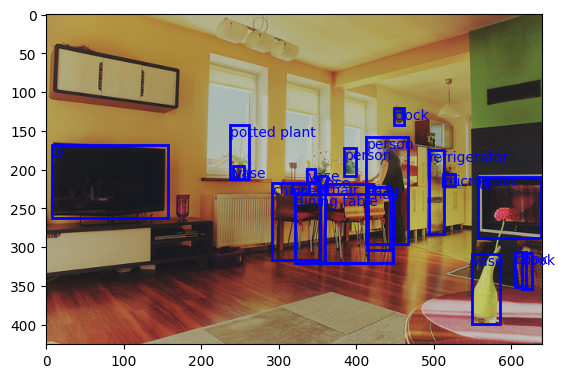

In [27]:
# Load the first image using COCO API
first_image_id = coco_dataset.ids[0]  # Get the ID of the first image in the dataset
image_data = coco.loadImgs(first_image_id)[0]
image_path = os.path.join(DATA_PATH, image_data['file_name'])

# Get the ground truth annotations for the first image
ann_ids = coco.getAnnIds(imgIds=first_image_id)
ground_truth = coco.loadAnns(ann_ids)

# Visualize the first image with ground truth bounding boxes and labels
img = Image.open(image_path).convert("RGB")  # Load the image using PIL
fig, ax = plt.subplots(1)
ax.imshow(img)

# Plot ground truth bounding boxes with labels for the first image
for annotation in ground_truth:
    bbox = annotation['bbox']
    label = coco.loadCats(annotation['category_id'])[0]['name']  # Get category label
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                             linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1], label, color='b', fontsize=10, va='top')  # Display label near the box

plt.show()

In [28]:
score_threshold = 0.75
iou_scores_total = []
low_iou_indices = []
counter = 0  # Counter to limit computation to the first 3 samples
for images, targets in tqdm(data_loader):
    if counter >= 3:  # Break the loop after processing 3 samples
        break

    with torch.no_grad():
        images = list(image for image in images)
        # Forward pass
        predictions = model(images)
        for pred, target in zip(predictions, targets):
            counter += 1
            if counter > 3:
                break

            # Extract predicted boxes and scores above threshold
            pred_boxes = pred['boxes'].detach().numpy()
            scores = pred['scores'].detach().numpy()
            # Filter boxes based on score threshold
            high_score_mask = scores > score_threshold
            pred_boxes = pred_boxes[high_score_mask]

            # Get ground truth annotations for the image
            image_id = target['image_id'].item()
            ann_ids = coco.getAnnIds(imgIds=image_id)
            ground_truth = coco.loadAnns(ann_ids)
            ground_truth_boxes = [anno['bbox'] for anno in ground_truth]

            # Calculate IoU for each ground truth box with predicted boxes
            iou_scores = []
            for pred_box in pred_boxes:
                ious = [calculate_iou(pred_box, gt_box) for gt_box in ground_truth_boxes]
                iou_scores.append(max(ious))  # Take the highest IoU per ground truth box

            # Calculate mean IoU for the entire sample
            iou_mean = sum(iou_scores) / len(iou_scores)
            iou_scores_total.append(iou_mean)
            if iou_mean < 0.2:
                low_iou_indices.append(counter - 1)
            # Print IoU for the current sample
            print(f"IoU for Sample {counter}: {iou_mean:.4f}")
# Calculate the mean IoU for the processed samples
mean_iou_model = sum(iou_scores_total) / len(iou_scores_total)
print(f"Mean IoU of the model (first 3 samples): {mean_iou_model:.4f}")

  0%|          | 1/5000 [00:06<8:30:10,  6.12s/it]

IoU for Sample 1: 0.5866


  0%|          | 2/5000 [00:10<7:28:26,  5.38s/it]

IoU for Sample 2: 0.9798


  0%|          | 3/5000 [00:15<7:08:28,  5.14s/it]

IoU for Sample 3: 0.4810
Mean IoU of the model (first 3 samples): 0.6825


  0%|          | 0/5000 [00:00<?, ?it/s]

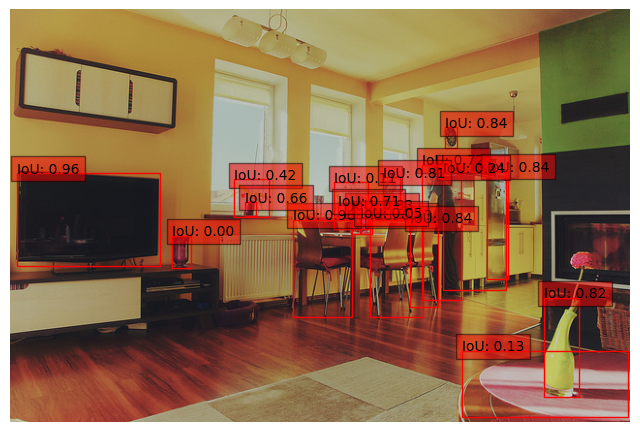

  0%|          | 1/5000 [00:07<10:00:19,  7.21s/it]

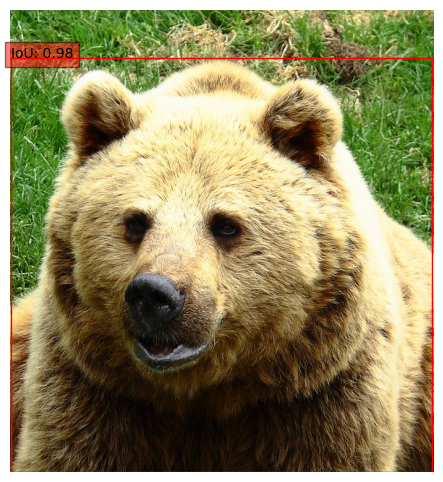

  0%|          | 2/5000 [00:11<7:35:58,  5.47s/it] 

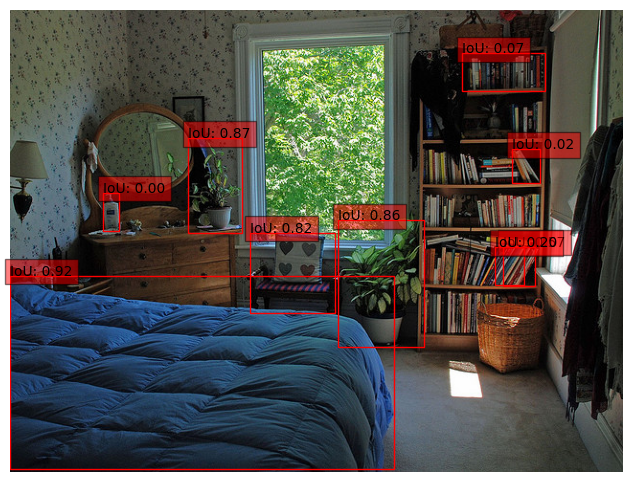

  0%|          | 3/5000 [00:17<7:48:36,  5.63s/it]

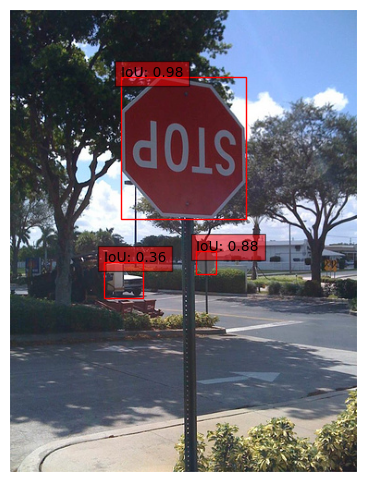

  0%|          | 4/5000 [00:24<8:24:37,  6.06s/it]


In [25]:
score_threshold = 0.75
counter = 0
for images, targets in tqdm(data_loader):
    if counter >= 4:
        break
    with torch.no_grad():
        images = list(image for image in images)
        # Forward pass
        predictions = model(images)
        for img, pred, target in zip(images, predictions, targets):
            counter += 1
            if counter > 4:
                break
            # Convert tensor image to PIL for visualization
            img_pil = to_pil_image(img)
            # Extract predicted boxes and scores above threshold
            pred_boxes = pred['boxes'].detach().numpy()
            scores = pred['scores'].detach().numpy()
            # Filter boxes based on score threshold
            high_score_mask = scores > score_threshold
            pred_boxes = pred_boxes[high_score_mask]
            # Get ground truth annotations for the image
            image_id = target['image_id'].item()
            ann_ids = coco.getAnnIds(imgIds=image_id)
            ground_truth = coco.loadAnns(ann_ids)
            ground_truth_boxes = [anno['bbox'] for anno in ground_truth]
            # Calculate IoU for each predicted box with ground truth boxes
            iou_scores = []
            for pred_box in pred_boxes:
                ious = [calculate_iou(pred_box, gt_box) for gt_box in ground_truth_boxes]
                iou_scores.append(max(ious))  # Take the highest IoU
            # Display image with predicted boxes and IoU information
            plt.figure(figsize=(8, 6))
            plt.imshow(img_pil)
            ax = plt.gca()
            for box, iou in zip(pred_boxes, iou_scores):
                box = list(box)
                rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                plt.text(box[0], box[1], f"IoU: {iou:.2f}", bbox=dict(facecolor='red', alpha=0.5))
            plt.axis('off')
            plt.show()